In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
#import sys, h5py, binascii

import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh
#from pygimli.meshtools.mesh import exportHDF5Mesh
#from pygimli.meshtools import convertMesh

In [3]:
#Ici on commence par définir un maillage rectangulaire homogène

xmin, xmax = -0.02, 0.0 #On définit les limites en x du maillage
zmin, zmax = -0.3, 0. #On définit les limites en z du maillage

dx = 0.01 #On définit le pas de la maille

In [4]:
xreg = np.arange(xmin, xmax + dx, dx, 'float') #On calcule les coordonnées des mailles
zreg = np.arange(zmin, zmax + dx, dx, 'float')

In [5]:
mesh1 = pg.Mesh(2) #On crée un maillage vide 
mesh1.create2DGrid(xreg, zreg, 0) #On crée le maillage
for c in mesh1.cells(): #On marque les cellules
    c.setMarker(1)

In [6]:
#A présent on crée une zone grâce à un polygone

poly = pg.Mesh(2)  # empty 2d mesh
nStart = poly.createNode(0.0, 0.0, 0.0) #On crée un noeud de départ, on travaille en 2D donc le dernier terme vaut 0.0

nA = nStart #On définit le noeud de départ
for z in zreg[1:]: #On démarre de 1 et on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly.createNode(xmax, z, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée

z2 = -0.3 #On définit une altitude z2 
nA = poly.createNode(xmax, z2, 0.0) #On crée un noeud
poly.createEdge(nB, nA) #On fait le lien entre le dernier noeud crée et celui-là
nB = poly.createNode(xmin, z2, 0.0) #On crée un autre noeud en symétrique
poly.createEdge(nA, nB) #On fait le lien avec le noeud précédent
nC = poly.createNode(xmin, -0.8, 0.0)
poly.createEdge(nB, nC)
nD = poly.createNode(0.4, -0.8, 0.0)
poly.createEdge(nC, nD)
nE = poly.createNode(0.4, 0.0, 0.0)
poly.createEdge(nD, nE)
poly.createEdge(nE, nStart) #On ferme le polygone!

tri = pg.TriangleWrapper(poly) #On appelle la fonction triangle
tri.setSwitches('-pzeAfaq31') #On rentre tout un tas de commandes rigolotes pour générer les triangles
# Ici on a :
# p : planar straight line graph ==> fichier poly
# z : on démarre le comptage à 0
# A : assigne un attribut à chaque triangle qui indique à quel segment il appartient et est lié
# f : algorithme de triangulation (?)
# a : impose une surface contrainte pour chaque triangle on peut ajouter un nombre si on veut préciser
# q31 : impose que les triangles générés aient au minimun des angles de 20° On peut ajouter un nombre derrière pour préciser le nombre que l'o souhaite

In [7]:
#A présent on génère le maillage hétérogène

mesh2 = pg.Mesh(2) #On appelle le second maillage autour du premier
tri.generate(mesh2) #On génère les triangles au sein du polygone précédemment crée

In [8]:
for cell in mesh2.cells(): #On génère les cellules de chaque maille
    cell.setMarker(2)
    

In [9]:
#Fusion des deux maillages pour créer un maillage hybride
#mesh3 = merge2Meshes(mesh1, mesh2) #On peut faire fusionner les deux maillages ainsi crées en un seul

#a=showMesh(mesh2, mesh1.cellMarkers(), label="Region marker")

In [10]:
#Création d'une fonction pour interpoler la charge au fond du trou

#Définition des paramètres initiaux
p=1 #coordonnées xy des noeuds du maillage
d=30 #profondeur du trou en cm
radius=2 #rayon du trou en cm
h_0=-95 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1=10 #hauteur d'eau au fond du trou en cm

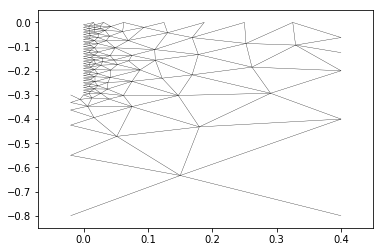

(<matplotlib.axes._subplots.AxesSubplot at 0x7f85d684f7b8>, None)

In [25]:
showMesh(mesh2)

In [12]:
mesh=mesh2
pg_pos = mesh.positions()
mesh_pos = np.array((np.array(pg.x(pg_pos)), np.array(pg.y(pg_pos)), np.array(pg.z(pg_pos)))).T
mesh_cells = np.zeros((mesh.cellCount(), 3))
for i, cell in enumerate(mesh.cells()):
        mesh_cells[i] = cell.ids()

In [ ]:
print(mesh_pos.shape)
print(mesh_pos)

In [28]:
mesh.boundaries() #utiliser la tabulation pour lister les operations possibles sur un objet. mesh.'tab par exemple

mesh.cellCount()

222

In [32]:
a=np.array([1,2])
np.cross(a,a)

array(0)

In [45]:
for c in mesh.cells():
    print([[node.x(),node.y()] for node in c.nodes()])
    

[[0.010753377629, -0.285], [0.0, -0.29], [0.008863965212, -0.295]]
[[0.150177441689, -0.633557928406], [0.179813355773, -0.432295126134], [0.051680360248, -0.471568379339]]
[[0.051680360248, -0.471568379339], [-0.02, -0.425], [-0.02, -0.55]]
[[0.012995955939, -0.312682152341], [0.0, -0.3], [-0.005421352026, -0.318555334704]]
[[-0.005421352026, -0.318555334704], [-0.02, -0.33125], [0.006422196202, -0.346875]]
[[0.017127946667, -0.245], [0.037970645029, -0.248277120034], [0.041354972884, -0.227451560841]]
[[0.010753377629, -0.205], [0.0, -0.19999999999999998], [0.0, -0.21]]
[[0.0, -0.27999999999999997], [0.0, -0.29], [0.010753377629, -0.285]]
[[0.0, -0.09999999999999999], [0.0, -0.11], [0.017127946667, -0.105]]
[[0.008863965212, -0.265], [0.010753377629, -0.255], [0.0, -0.26]]
[[0.0, -0.27], [0.0, -0.27999999999999997], [0.017127946667, -0.275]]
[[0.047297333058999996, -0.155474960878], [0.070229495442, -0.158939476962], [0.07519653643, -0.136285218045]]
[[0.0, -0.27999999999999997], [0.

In [46]:
#c=mesh.cell(0) renvoie la cellule 0

def crossprod(c):

    node0=c.node(0)
    a0=np.array([node0.x(),node0.y()])
    node1=c.node(1)
    a1=np.array([node1.x(),node1.y()])
    node2=c.node(2)
    a2=np.array([node2.x(),node2.y()])

    #faire un produit vectoriel entre node[1]-node[0] et node[2]-node[0]. 
    return np.cross(a1-a0,a2-a0)

crossprod(mesh.cell(0))
# si négatif, node[1],node[2]=node[2],node[1]
# afficher node[0] node[1] node[2]
#c.boundaryNodes

array(9.808671420500008e-05)

In [57]:
f=open("maillage.txt","w")

for c in mesh.cells(): 
    assert crossprod(c) > 0 # arrete tout si c'est faux.
    for node in c.nodes():
        #f.write(str([[node.x(),node.y()]]))
        f.write("{} {} \n".format(node.x(),node.y()))
f.close()
    

In [58]:
!cat maillage.txt

0.010753377629 -0.285 
0.0 -0.29 
0.008863965212 -0.295 
0.150177441689 -0.633557928406 
0.179813355773 -0.432295126134 
0.051680360248 -0.471568379339 
0.051680360248 -0.471568379339 
-0.02 -0.425 
-0.02 -0.55 
0.012995955939 -0.312682152341 
0.0 -0.3 
-0.005421352026 -0.318555334704 
-0.005421352026 -0.318555334704 
-0.02 -0.33125 
0.006422196202 -0.346875 
0.017127946667 -0.245 
0.037970645029 -0.248277120034 
0.041354972884 -0.227451560841 
0.010753377629 -0.205 
0.0 -0.19999999999999998 
0.0 -0.21 
0.0 -0.27999999999999997 
0.0 -0.29 
0.010753377629 -0.285 
0.0 -0.09999999999999999 
0.0 -0.11 
0.017127946667 -0.105 
0.008863965212 -0.265 
0.010753377629 -0.255 
0.0 -0.26 
0.0 -0.27 
0.0 -0.27999999999999997 
0.017127946667 -0.275 
0.047297333058999996 -0.155474960878 
0.070229495442 -0.158939476962 
0.07519653643 -0.136285218045 
0.0 -0.27999999999999997 
0.010753377629 -0.285 
0.017127946667 -0.275 
0.0 -0.11 
0.0 -0.12 
0.010753377629 -0.11499999999999999 
0.026936618087 -0.2932

In [1]:
pg.x?

Object `pg.x` not found.


In [ ]:
l=list(pg_pos)

In [ ]:
l[1]

In [ ]:
list(l[1])

In [ ]:
mesh.saveAscii('mesh.a')
